# Problem Statement:

Given the dataset, train the model to segment nuclei in the images using mask-rcnn.

Plot the maP (mean average precision) of the training and testing data

• Create a proper folder structure of all your files including the model weights (exclude
the datasets) and upload on google drive. Google drive file name should be
(firstname_lastname.zip) and share the link with us.

• Try using relative imports in the code or else comment where we have to make the
path changes wrt our machine

• Write down the approach in detail in a text document and explain why have you taken
those steps.

• You are free to use any libraries of your own given above steps are followed

• [Link to the data set here](https://drive.google.com/open?id=1BdIovcY9NzwXhP146u98xcXRp_ZqO-zv)

# List of related studies done before proceeding to problem statement

1. [U-Net: Convolutional Networks for Biomedical
Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

2. [Unet for Image Segmentation](https://github.com/zhixuhao/unet)

3. [Mask-RCNN](https://arxiv.org/pdf/1703.06870.pdf)

4. [Fast-RCNN](https://arxiv.org/pdf/1504.08083.pdf) 

5. [Playing around with RCNN - State of the art Object Detector](https://cs.stanford.edu/people/karpathy/rcnn/) - Beautiful blog and references by "Andrej Karpathy".

6. [Rich feature hierarchies for accurate object detection and semantic segmentation
Tech report (v5)](https://arxiv.org/pdf/1311.2524.pdf)

7. [Double-Head RCNN: Rethinking Classification and
Localization for Object Detection](https://arxiv.org/pdf/1904.06493.pdf)

8. [Grid-RCNN](https://arxiv.org/pdf/1811.12030.pdf)

9. [Mean Average Prediction matrices](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)

In [0]:
"""
Importing supported libraries. 

"""
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
from os.path import join
import glob
import sys
import random
from tqdm import tqdm
import itertools
from itertools import chain
import skimage
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

%matplotlib inline

In [2]:
## GOOGLE DRIVE AUTHENTICATION

##### PLEASE CHANGE THIS CELL ACCORDING TO YOUR MACHINE.

"""
We firt try to establish google drive authentication in which I have stored the dataset. Please authenticate your drive with a preloaded dataset incase 
you are following the same approch.


We then search for the datatset files, namely the training and test zip files and then extract in the google colab drive.
We then clean up all the zip files since all the datasets needed for further progress is already extracted.

"""

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fid = drive.ListFile({'q':"title='stage1_train.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('stage1_train.zip')
with zipfile.ZipFile("stage1_train.zip","r") as zip_ref:
    zip_ref.extractall("training_data/")
os.unlink('stage1_train.zip')

fid = drive.ListFile({'q':"title='stage1_test.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('stage1_test.zip')
with zipfile.ZipFile("stage1_test.zip","r") as zip_ref:
    zip_ref.extractall("test_data/")
os.unlink('stage1_test.zip')

W0714 10:44:10.813087 139796952061824 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

In [0]:
"""
Test and Training images path. 
Please change with respect to the target running machine.

"""
training_path = 'training_data/'
test_path = 'test_data/'

# Get train and test IDs
train_ids = next(os.walk(training_path))[1]
test_ids = next(os.walk(test_path))[1]

In [0]:
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3

In [5]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = training_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

  0%|          | 0/670 [00:00<?, ?it/s]

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [05:50<00:00,  3.68it/s]


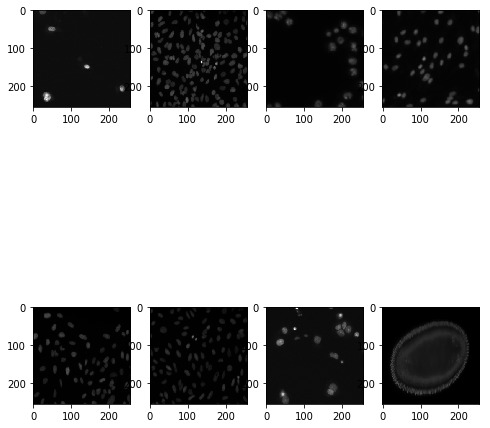

In [6]:
n_row = 2
n_col = 4

plt.figure(figsize=(8,10))

for i in range(8):
  plt.subplot(n_row,n_col,i+1)
  img = X_train[i]
  plt.imshow(img,cmap='Greys')

In [6]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:01<00:00, 33.17it/s]


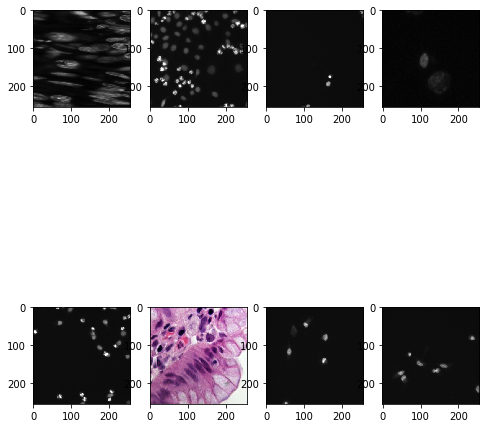

In [8]:
n_row = 2
n_col = 4

plt.figure(figsize=(8,10))

for i in range(8):
  plt.subplot(n_row,n_col,i+1)
  img = X_test[i]
  plt.imshow(img,cmap='Greys')

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2)
print('x_train',x_train.shape)
print('x_test',x_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

x_train (536, 256, 256, 3)
x_test (134, 256, 256, 3)
y_train (536, 256, 256, 1)
y_test (134, 256, 256, 1)


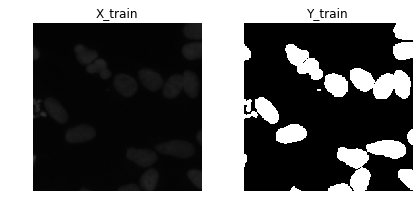

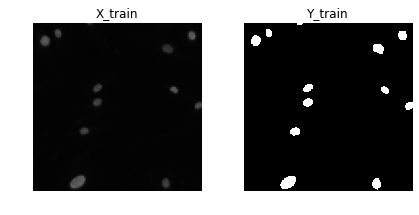

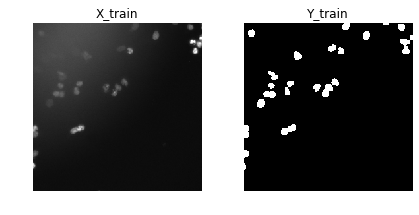

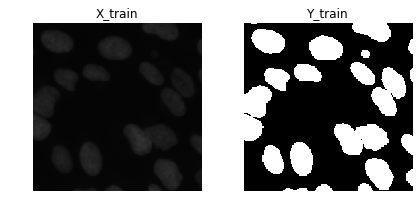

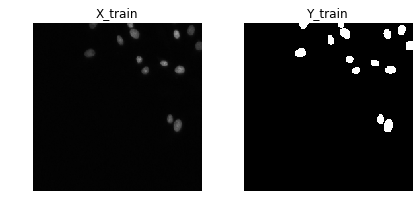

In [10]:
"""
Plotting random 5 training examples and their respective masks
"""
def plotTrainData(a,b):
    for i in range(5):
        ix = random.randint(0, len(train_ids))
        plt.subplot(1,2,1)
        plt.title("X_train")
        imshow(a[ix])
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.title("Y_train")
        imshow(np.squeeze(b[ix]))
        plt.axis('off')
        plt.show()
plotTrainData(X_train,Y_train)

# Helper functions


#### Mean average prediction using IOU:

<img src="https://miro.medium.com/max/700/1*FrmKLxCtkokDC3Yr1wc70w.png">

In [0]:
"""
Main validation matrix: Intersection over Union

IoU measures the overlap between 2 boundaries. We use that to measure how much our predicted boundary 
overlaps with the ground truth (the real object boundary). In some datasets, we predefine an IoU 
threshold (say 0.5) in classifying whether the prediction is a true positive or a false positive.

"""

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [0]:
def plotPredictions(a,b,c,d,e):
    model = e
    # Threshold predictions
    preds_train = model.predict(a[:int(a.shape[0]*0.9)], verbose=1)
    preds_val = model.predict(a[int(a.shape[0]*0.9):], verbose=1)
    preds_test = model.predict(c, verbose=1)
    preds_train_t = (preds_train > 0.5).astype(np.uint8)
    preds_val_t = (preds_val > 0.5).astype(np.uint8)
    preds_test_t = (preds_test > 0.5).astype(np.uint8)
    # Perform a sanity check on some random training samples
    ix = random.randint(0, len(preds_train_t))
    plt.subplot(1,3,1)
    plt.title("X_train")
    plt.axis('off')
    imshow(a[ix])
    plt.subplot(1,3,2)
    plt.title("Y_train")
    plt.axis('off')
    imshow(np.squeeze(b[ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_train_t[ix]))
    plt.show()
    # Perform a sanity check on some random validation samples
    ix = random.randint(0, len(preds_val_t))
    plt.subplot(1,3,1)
    plt.title("X_test")
    plt.axis('off')
    imshow(a[int(a.shape[0]*0.9):][ix])
    plt.subplot(1,3,2)
    plt.title("Y_test")
    plt.axis('off')
    imshow(np.squeeze(b[int(b.shape[0]*0.9):][ix]))
    plt.subplot(1,3,3)
    plt.title("Prediction")
    plt.axis('off')
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

# Defining default U-Net model and Training without Image augumentation (15 epochs)

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png">

In [0]:
def default_unet():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(input = inputs, output = conv10)

  return model

In [15]:
model = default_unet()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mean_iou,'accuracy'])
model.summary()

W0714 04:17:28.422757 140411316668288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0714 04:17:28.466570 140411316668288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0714 04:17:28.473560 140411316668288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0714 04:17:28.518323 140411316668288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0714 04:17:28.584797 140411316668288 deprec

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [0]:
plot_model(model, to_file='model_Unet_default.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image(retina=True, filename='model_Unet_default.png')

In [16]:
checkpointer = ModelCheckpoint('model_1_default_unet_checkpoints.h5', verbose=1, save_best_only=True)

results = model.fit(x_train,y_train, validation_data=(x_test,y_test), batch_size=16, epochs=15, callbacks=[checkpointer])

Train on 536 samples, validate on 134 samples
Epoch 1/15
536/536 [==============================] - 61s 114ms/step - loss: 0.7219 - mean_iou: 0.4198 - acc: 0.8356 - val_loss: 0.6874 - val_mean_iou: 0.4230 - val_acc: 0.8480

Epoch 00001: val_loss improved from inf to 0.68745, saving model to model_1_default_unet_checkpoints.h5
Epoch 2/15
536/536 [==============================] - 36s 68ms/step - loss: 0.6829 - mean_iou: 0.4228 - acc: 0.8386 - val_loss: 0.6764 - val_mean_iou: 0.4215 - val_acc: 0.8480

Epoch 00002: val_loss improved from 0.68745 to 0.67635, saving model to model_1_default_unet_checkpoints.h5
Epoch 3/15
536/536 [==============================] - 37s 70ms/step - loss: 0.6723 - mean_iou: 0.4218 - acc: 0.8386 - val_loss: 0.6656 - val_mean_iou: 0.4211 - val_acc: 0.8480

Epoch 00003: val_loss improved from 0.67635 to 0.66564, saving model to model_1_default_unet_checkpoints.h5
Epoch 4/15
536/536 [==============================] - 37s 69ms/step - loss: 0.6620 - mean_iou: 0.4208 

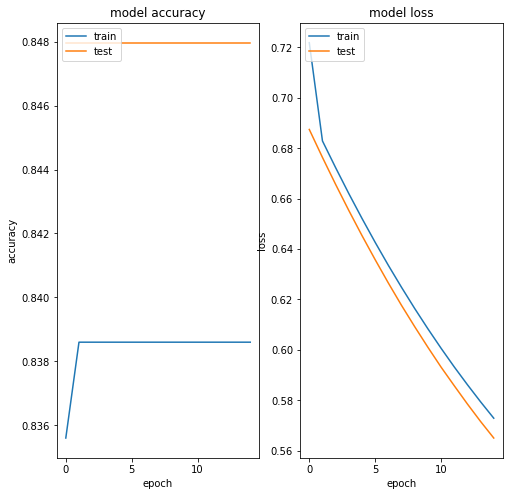

In [17]:
plot_learning_curve(results)
plt.show()

In [0]:
model.save('model1_default_unet_complete_model.h5')

### Prediction using Default U-Net model

In [0]:
fid = drive.ListFile({'q':"title='model1_default_unet_complete_model.h5'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('model1_default_unet_complete_model.h5')

In [25]:
model = load_model('model1_default_unet_complete_model.h5',custom_objects={'mean_iou':mean_iou})

W0714 11:30:50.243576 139796952061824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



134/134 [==============================] - 6s 42ms/step


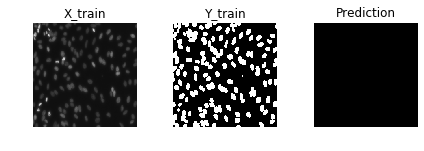

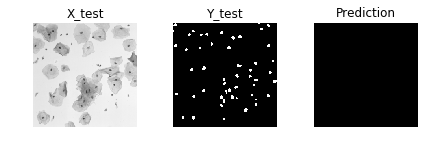

In [29]:
plotPredictions(x_train,y_train,x_test,y_test,model)

## Inferences from Default U-Net model:

1. mean_IOU is not increasing by using default U-Net architecture, but surely we see that validation loss has constantly decreased. We need to tweak the architecture but before doing so, let's try to identify where out network is struggling.

2. Relu might not be performing well on such architectures since we can not directly make all the negative class weight gradients to zero. We can try either 'ELU' or LeakyRelu.

3. All the images are pretty flat and un-normalized. This could be one of the reasons as well since the mask over the images are normalized, the values of gradients is not able to identify most loudly screaming features after masking

# Model 2: Tweak in activation function and simpler architecture with image scaling

In [0]:
def tweaked_unet():
  inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
  s = Lambda(lambda x: x / 255) (inputs)

  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
  c1 = Dropout(0.1) (c1)
  c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Dropout(0.1) (c2)
  c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Dropout(0.2) (c3)
  c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Dropout(0.2) (c4)
  c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Dropout(0.3) (c5)
  c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Dropout(0.2) (c6)
  c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Dropout(0.2) (c7)
  c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Dropout(0.1) (c8)
  c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Dropout(0.1) (c9)
  c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [20]:
model = tweaked_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou,'accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 256, 256, 16) 0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 

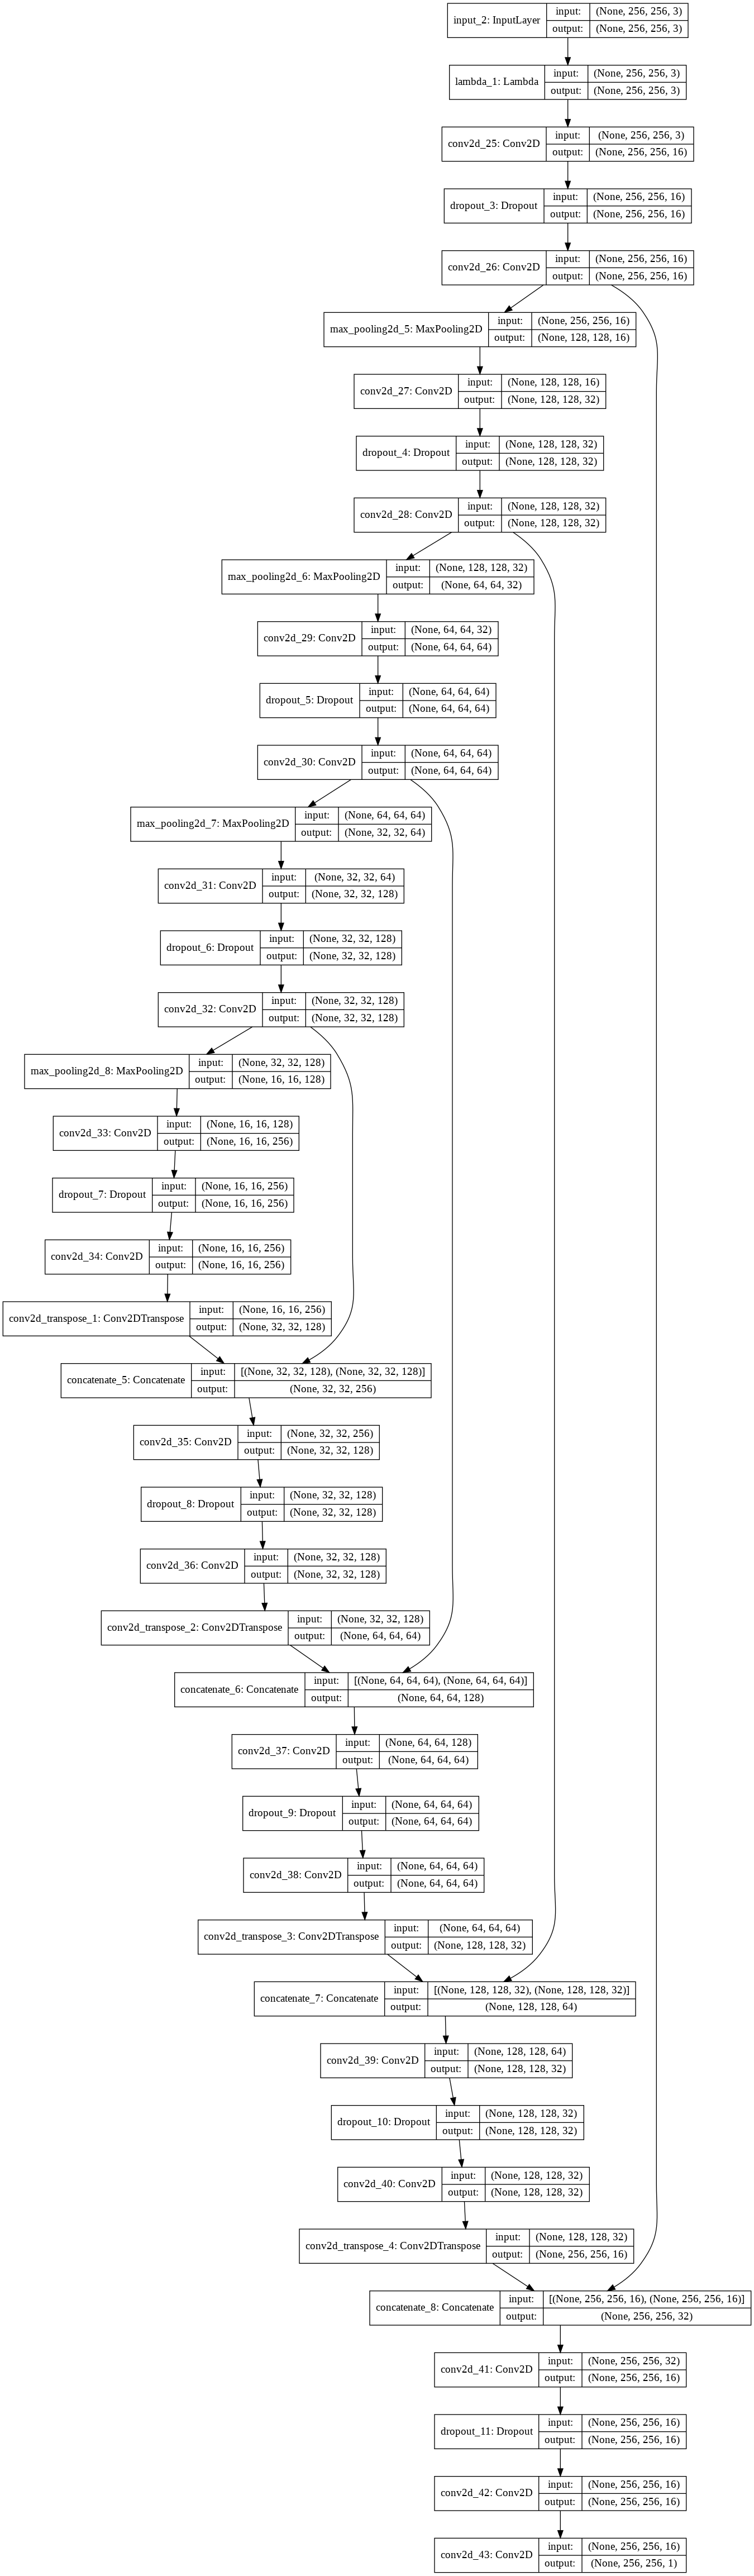

In [35]:
plot_model(model, to_file='model_Unet_tweaked.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_Unet_tweaked.png')

In [21]:
checkpointer = ModelCheckpoint('model_2_tweaked_unet_checkpointers.h5', verbose=1, save_best_only=True)

results = model.fit(x_train, y_train, validation_data=(x_test,y_test), batch_size=16, epochs=50, callbacks=[checkpointer])

Train on 536 samples, validate on 134 samples
Epoch 1/50
536/536 [==============================] - 15s 28ms/step - loss: 0.3838 - mean_iou: 0.4348 - acc: 0.8427 - val_loss: 0.1982 - val_mean_iou: 0.5250 - val_acc: 0.9244

Epoch 00001: val_loss improved from inf to 0.19824, saving model to model_2_tweaked_unet_checkpointers.h5
Epoch 2/50
536/536 [==============================] - 8s 14ms/step - loss: 0.1643 - mean_iou: 0.5844 - acc: 0.9346 - val_loss: 0.1190 - val_mean_iou: 0.6301 - val_acc: 0.9535

Epoch 00002: val_loss improved from 0.19824 to 0.11898, saving model to model_2_tweaked_unet_checkpointers.h5
Epoch 3/50
536/536 [==============================] - 8s 14ms/step - loss: 0.1202 - mean_iou: 0.6629 - acc: 0.9538 - val_loss: 0.1859 - val_mean_iou: 0.6873 - val_acc: 0.9421

Epoch 00003: val_loss did not improve from 0.11898
Epoch 4/50
536/536 [==============================] - 8s 14ms/step - loss: 0.1152 - mean_iou: 0.7015 - acc: 0.9558 - val_loss: 0.1127 - val_mean_iou: 0.7164 -

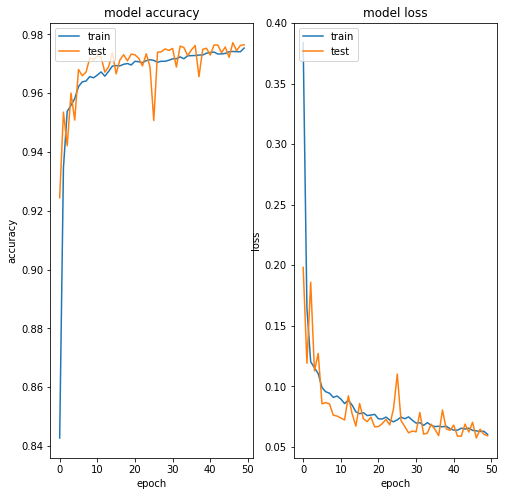

In [22]:
plot_learning_curve(results)
plt.show()

In [0]:
model.save('model2_tweaked_unet_complete_model.h5')

134/134 [==============================] - 0s 3ms/step


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


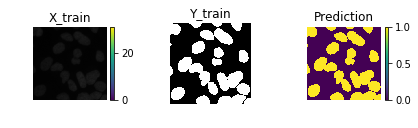

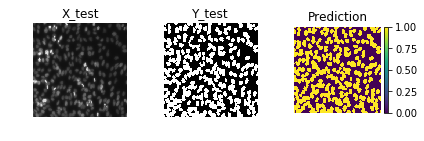

In [26]:
plotPredictions(x_train,y_train,x_test,y_test,model)

#### huge improvement over the previous model

##### Inference

1. Relu was not a great choice and hence proved for this particular dataset

2. Simpler architecture, with much lesser parameters and image scaling at the imput is very important.

3. Still no augumentation. So lets try few of the general ones and lets test the same model again

# Adding Image Augumentation (did not work!!) (Ignore during evaluation)

#### the data augumentation techniques tried below are reffered from this U-Net official research paper. 

The paper suggest 
- shift and rotation invariance as well as robustness to deformations and gray value variations. 

- random elastic deformations of the training samples seem to be the key concept to train
a segmentation network with very few annotated images.

- Dropouts are already used in the network. 

Link to the paper is mentioned in the reference section at the beginning.


In [0]:
def get_train_test_augmented(batch_size=16):
    X_train, X_test, Y_train, Y_test = x_train,x_test,y_train,y_test
    
    # Image data generator distortion options
    data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')  #use 'constant'??


    # Train data, provide the same seed and keyword arguments to the fit and flow methods
    X_datagen = ImageDataGenerator(**data_gen_args)
    Y_datagen = ImageDataGenerator(**data_gen_args)
    X_datagen.fit(X_train, augment=True)
    Y_datagen.fit(Y_train, augment=True)
    X_train_augmented = X_datagen.flow(X_train, batch_size=batch_size, shuffle=True)
    Y_train_augmented = Y_datagen.flow(Y_train, batch_size=batch_size, shuffle=True)
     
    
    # Test data, no data augmentation, but we create a generator anyway
    X_datagen_val = ImageDataGenerator()
    Y_datagen_val = ImageDataGenerator()
    X_datagen_val.fit(X_test, augment=True)
    Y_datagen_val.fit(Y_test, augment=True)
    X_test_augmented = X_datagen_val.flow(X_test, batch_size=batch_size, shuffle=True)
    Y_test_augmented = Y_datagen_val.flow(Y_test, batch_size=batch_size, shuffle=True)
    
    
    # combine generators into one which yields image and masks
    train_generator = zip(X_train_augmented, Y_train_augmented)
    test_generator = zip(X_test_augmented, Y_test_augmented)
    
    return train_generator, test_generator, X_train, X_test, Y_train, Y_test

In [40]:
batch_size=16
train_generator, test_generator, X_train, X_val, Y_train, Y_val = get_train_test_augmented(batch_size=batch_size)
model.fit_generator(train_generator, validation_data=test_generator, validation_steps=batch_size/2, steps_per_epoch=len(X_train)/(batch_size*2), epochs=30)

Epoch 1/30
17/16 [==============================] - 10s 570ms/step - loss: 0.5308 - mean_iou: 0.4016 - acc: 0.8102 - val_loss: 0.4987 - val_mean_iou: 0.4260 - val_acc: 0.8124
Epoch 2/30
17/16 [==============================] - 5s 276ms/step - loss: 0.4261 - mean_iou: 0.4263 - acc: 0.8334 - val_loss: 0.4946 - val_mean_iou: 0.4251 - val_acc: 0.8062
Epoch 3/30
17/16 [==============================] - 6s 354ms/step - loss: 0.4249 - mean_iou: 0.4255 - acc: 0.8391 - val_loss: 0.4905 - val_mean_iou: 0.4257 - val_acc: 0.8095
Epoch 4/30
17/16 [==============================] - 6s 357ms/step - loss: 0.4463 - mean_iou: 0.4250 - acc: 0.8220 - val_loss: 0.4753 - val_mean_iou: 0.4249 - val_acc: 0.8191
Epoch 5/30
17/16 [==============================] - 6s 364ms/step - loss: 0.4242 - mean_iou: 0.4248 - acc: 0.8343 - val_loss: 0.5604 - val_mean_iou: 0.4247 - val_acc: 0.7845
Epoch 6/30
17/16 [==============================] - 6s 346ms/step - loss: 0.4272 - mean_iou: 0.4240 - acc: 0.8339 - val_loss: 0.4

KeyboardInterrupt: ignored

Stopped image augumented training because the results decayed.

# Predictions on validation images

In [27]:
# Predict on test
preds_val = model.predict(x_test, verbose=1)
# Threshold predictions
preds_val_t = (preds_val > 0.5)

134/134 [==============================] - 1s 4ms/step


In [0]:
# Define IoU metric as a regular function, to manually check result
def cal_iou(A, B):
    intersection = np.logical_and(A, B)
    union = np.logical_or(A, B)
    iou = np.sum(intersection > 0) / np.sum(union > 0)
    return iou

In [29]:
# calcualte average iou of validation images, the result from tensorflow seems too high. 
iou=[]
for i in range(len(y_test)):
    iou.append(cal_iou(np.squeeze(y_test[i]), np.squeeze(preds_val_t[i])))
print('Average Validate IOU: {}'.format(round(np.mean(iou),2)))

Average Validate IOU: 0.84


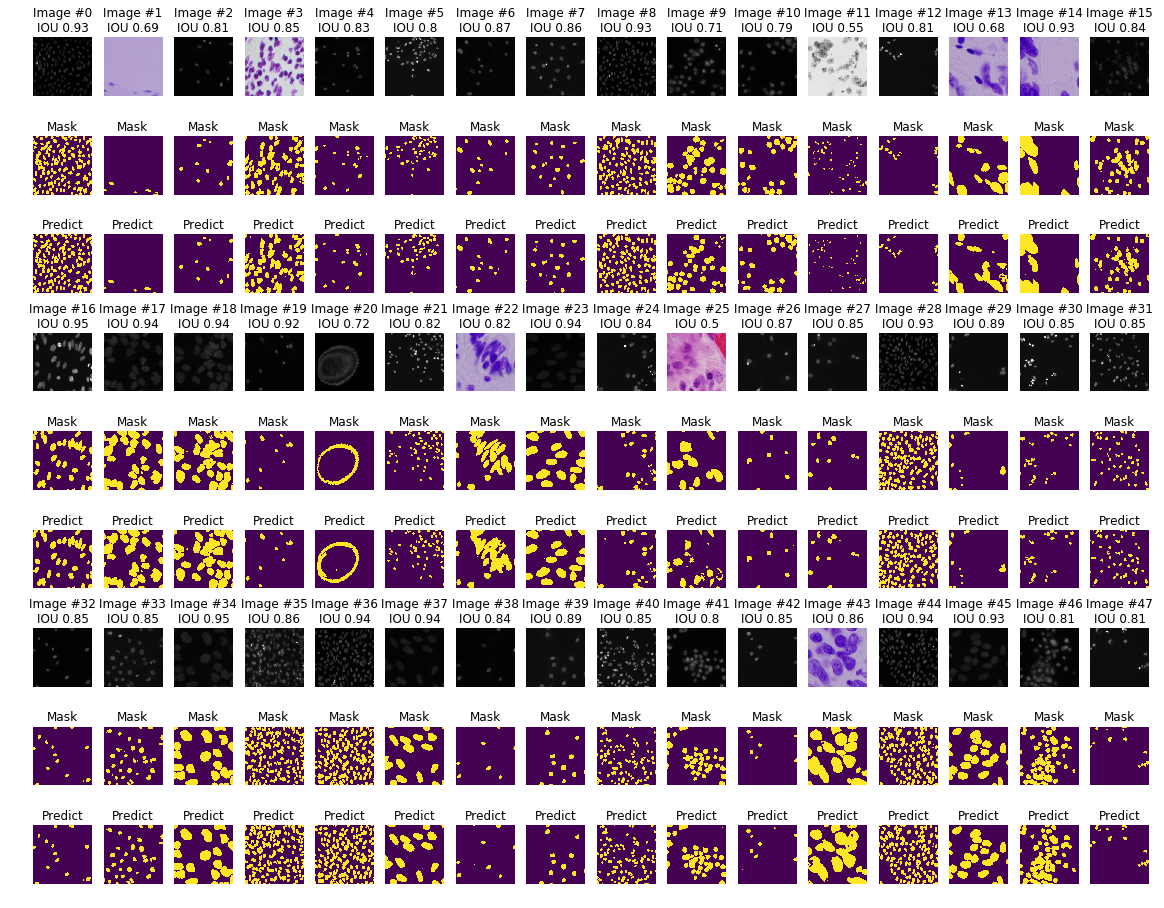

In [31]:
#plt.figure(figsize=(20,10.5))
plt.figure(figsize=(20,16))
x, y = 16,3
for i in range(y):  
    for j in range(x):
        # train image
        plt.subplot(y*3, x, i*3*x+j+1)
        pos = i*x+j
        plt.imshow(x_test[pos])
        plt.title('Image #{}\nIOU {}'.format(pos,round(cal_iou(np.squeeze(y_test[pos]), np.squeeze(preds_val_t[pos])),2)))
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+1)*x+j+1)
        plt.imshow(np.squeeze(y_test[pos]))
        plt.title('Mask')
        plt.axis('off')
        plt.subplot(y*3, x, (i*3+2)*x+j+1)
        plt.imshow(np.squeeze(preds_val_t[pos]))
        plt.title('Predict')
        plt.axis('off')
plt.show()

### Complete details of any 3 images

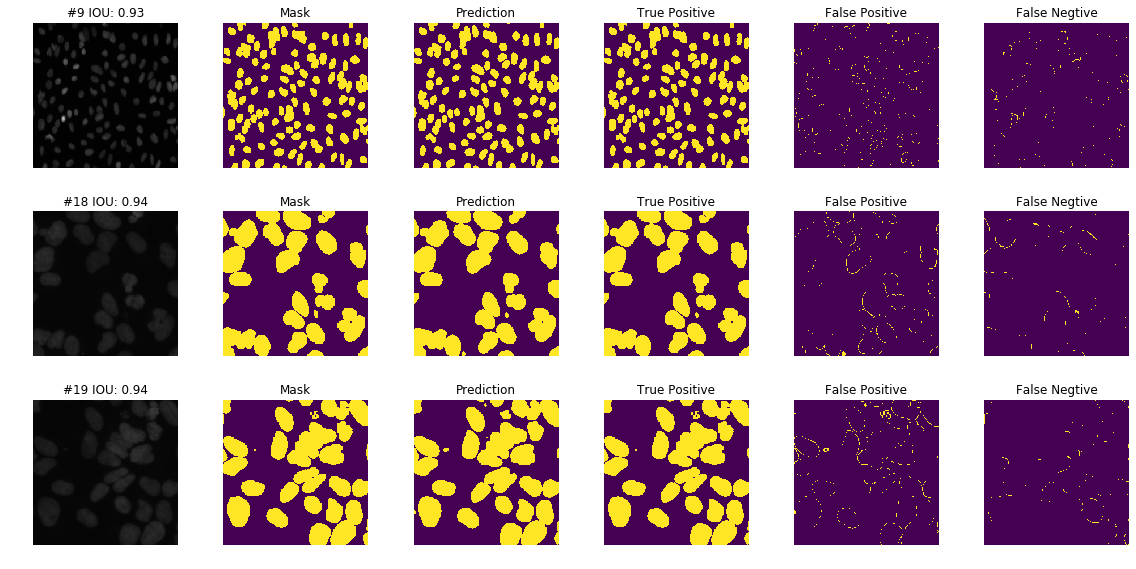

In [32]:
ixs = [8,17,18]
plt.figure(figsize=(16,8))
x, y =  6, len(ixs)
for i, ix in enumerate(ixs):  
    # original
    plt.subplot(y,x, i*x+1)
    plt.imshow(x_test[ix])
    plt.title('#{} IOU: {}'.format(ix+1,round(cal_iou(np.squeeze(y_test[ix]), np.squeeze(preds_val_t[ix])),2)))
    plt.axis('off')
    # grand true
    plt.subplot(y,x, i*x+2)
    plt.imshow(np.squeeze(y_test[ix]))
    plt.title('Mask')
    plt.axis('off')
    # prediction
    plt.subplot(y,x, i*x+3)
    pred = preds_val_t[ix]>0
    plt.imshow(np.squeeze(pred))
    plt.title('Prediction')
    plt.axis('off')
    # true positive
    plt.subplot(y,x, i*x+4)
    fp = np.logical_and(pred, y_test[ix])  
    plt.imshow(np.squeeze(fp))
    plt.title('True Positive')
    plt.axis('off')   
    # false positive
    plt.subplot(y,x, i*x+5)
    fp = np.logical_and(pred, np.logical_not(y_test[ix]))  
    plt.imshow(np.squeeze(fp))
    plt.title('False Positive') 
    plt.axis('off')       
    # false negtive
    plt.subplot(y,x, i*x+6)
    fn = np.logical_and(np.logical_not(pred), y_test[ix]) 
    plt.imshow(np.squeeze(fn))
    plt.title('False Negtive')     
    plt.axis('off')   
plt.tight_layout()
plt.show()

# Predictions on Test Images

In [0]:
model = load_model('model2_tweaked_unet_complete_model.h5', custom_objects={'mean_iou': mean_iou})

In [12]:
predictions = model.predict(X_test,verbose=1)

65/65 [==============================] - 5s 75ms/step


In [0]:
random_int = random.randint(1,50)

Original Test Image


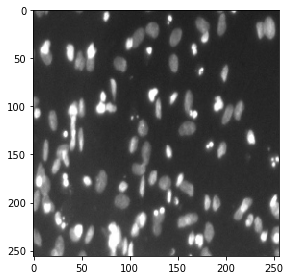

In [16]:
print('Original Test Image')
skimage.io.imshow(X_test[random_int])
plt.show()

Predicted Test Image Segmented


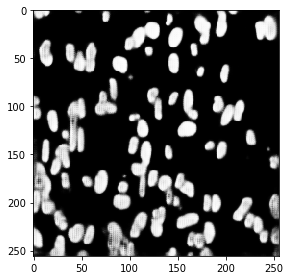

In [18]:
print('Predicted Test Image Segmented')
skimage.io.imshow(predictions[random_int][:,:,0])
plt.show()